## Nearest neighbor for spine injury classification

In this homework notebook we use **nearest neighbor classification** to classify back injuries for patients in a hospital, based on measurements of the shape and orientation of their pelvis and spine.

The data set contains information from **310** patients. For each patient, there are: six measurements (the x) and a label (the y). The label has **3** possible values, `’NO’` (normal), `’DH’` (herniated disk), or `’SL’` (spondilolysthesis). 

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import _hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingRegressor

%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.2)

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

import pickle
from pickle import dump, load

from pycaret.classification import *

pd.options.display.max_columns= None
#pd.options.display.max_rows = None

### Data Exploration

In [2]:
df = pd.read_csv("spine.csv")

In [3]:
df

,x1,x2,x3,x4,x5,x6,y
0,63.03,22.55,39.61,40.48,98.67,-0.25,DH
1,39.06,10.06,25.02,29.00,114.41,4.56,DH
2,68.83,22.22,50.09,46.61,105.99,-3.53,DH
3,69.30,24.65,44.31,44.64,101.87,11.21,DH
4,49.71,9.65,28.32,40.06,108.17,7.92,DH
...,...,...,...,...,...,...,...
305,47.90,13.62,36.00,34.29,117.45,-4.25,NO
306,53.94,20.72,29.22,33.22,114.37,-0.42,NO
307,61.45,22.69,46.17,38.75,125.67,-2.71,NO
308,45.25,8.69,41.58,36.56,118.55,0.21,NO


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      310 non-null    float64
 1   x2      310 non-null    float64
 2   x3      310 non-null    float64
 3   x4      310 non-null    float64
 4   x5      310 non-null    float64
 5   x6      310 non-null    float64
 6   y       310 non-null    object 
dtypes: float64(6), object(1)
memory usage: 17.1+ KB


In [5]:
df.describe(include='all')

,x1,x2,x3,x4,x5,x6,y
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310
unique,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,NaN,NaN,SL
freq,NaN,NaN,NaN,NaN,NaN,NaN,150
mean,60.496484,17.542903,51.930710,42.953871,117.920548,26.296742,NaN
std,17.236109,10.008140,18.553766,13.422748,13.317629,37.558883,NaN
min,26.150000,-6.550000,14.000000,13.370000,70.080000,-11.060000,NaN
25%,46.432500,10.667500,37.000000,33.347500,110.710000,1.600000,NaN
50%,58.690000,16.360000,49.565000,42.405000,118.265000,11.765000,NaN
75%,72.880000,22.120000,63.000000,52.692500,125.467500,41.285000,NaN


In [6]:
df.shape

(310, 7)

In [7]:
df.columns

Index(['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'y'], dtype='object')

### Data Visualization

### Univariate Data Exploration

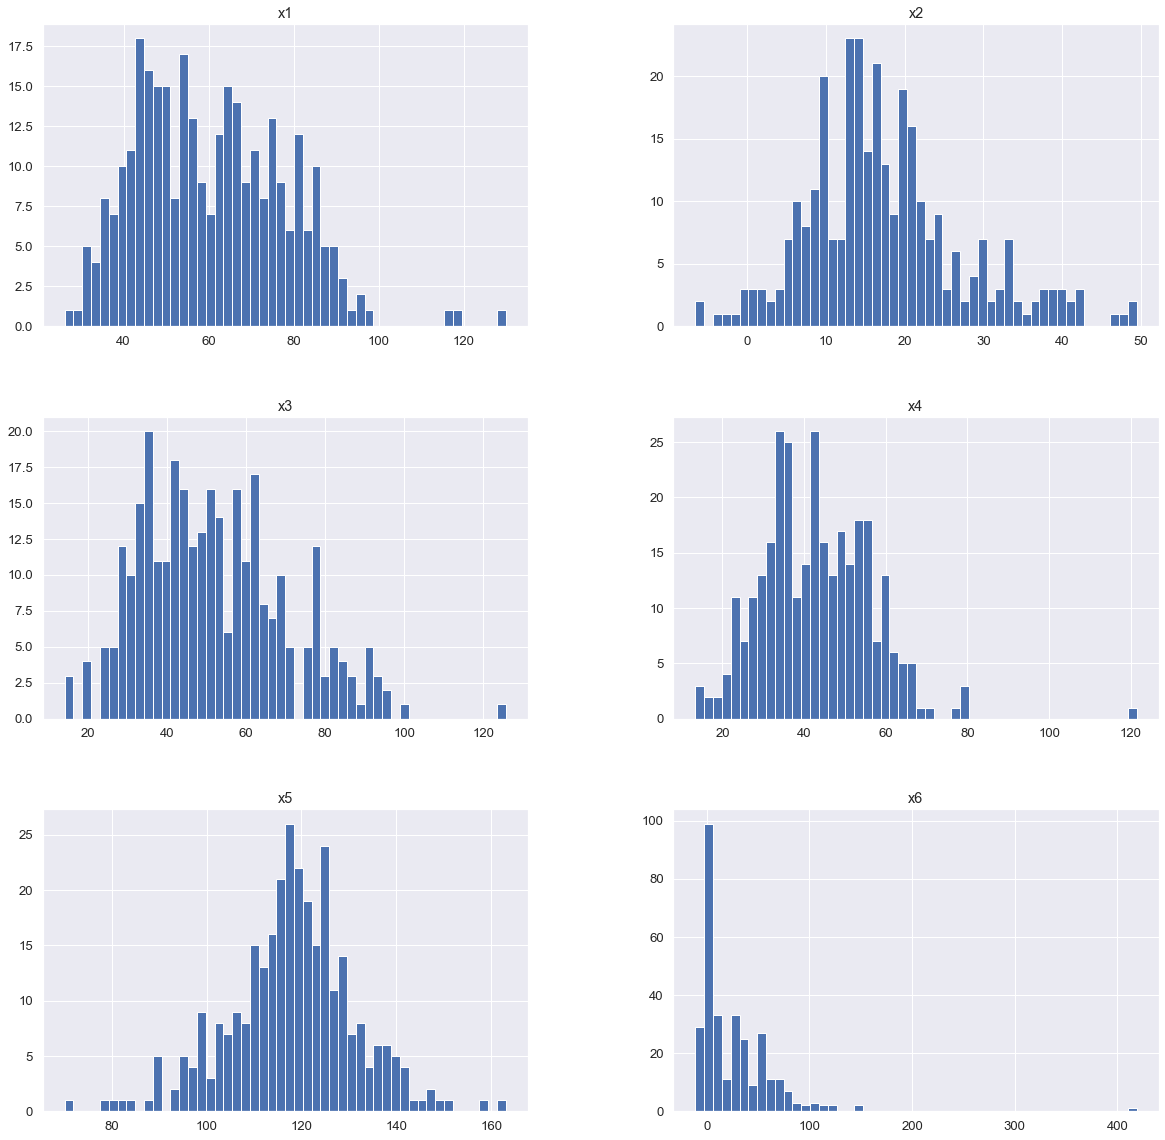

In [8]:
df.hist(bins=50, figsize=(20,20));

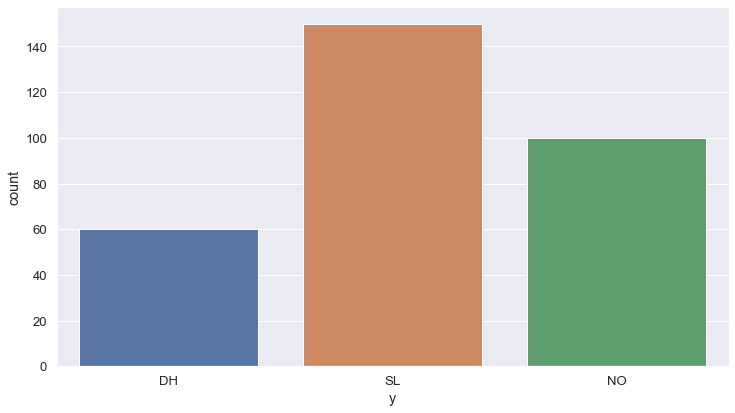

In [9]:
fig = plt.figure(figsize=(20,40))

plt.subplot(7,2,1)
sns.countplot(df.y)

plt.tight_layout()
plt.show()

In [10]:
df.corr()

,x1,x2,x3,x4,x5,x6
x1,1.000000,0.629186,0.717286,0.814959,-0.247484,0.638733
x2,0.629186,1.000000,0.432760,0.062327,0.032660,0.397840
x3,0.717286,0.432760,1.000000,0.598389,-0.080368,0.533665
x4,0.814959,0.062327,0.598389,1.000000,-0.342147,0.523571
x5,-0.247484,0.032660,-0.080368,-0.342147,1.000000,-0.026073
x6,0.638733,0.397840,0.533665,0.523571,-0.026073,1.000000


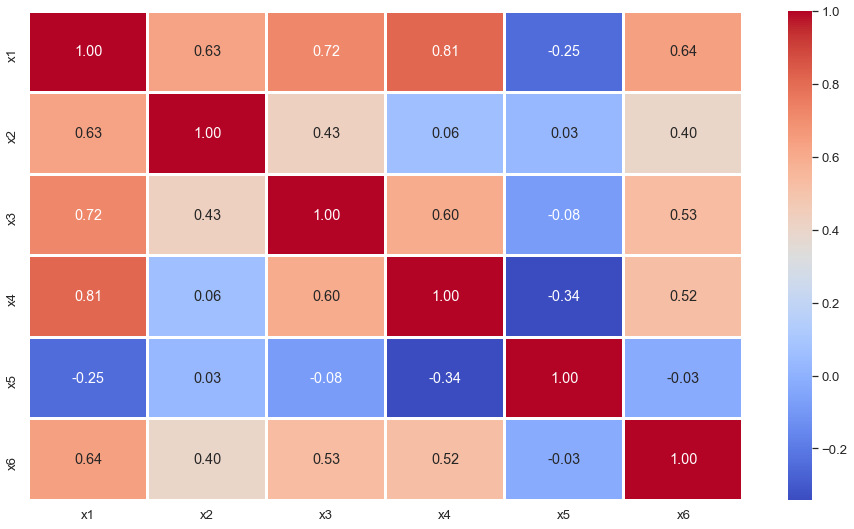

In [11]:
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,fmt='.2f',linewidths=2)
plt.show()

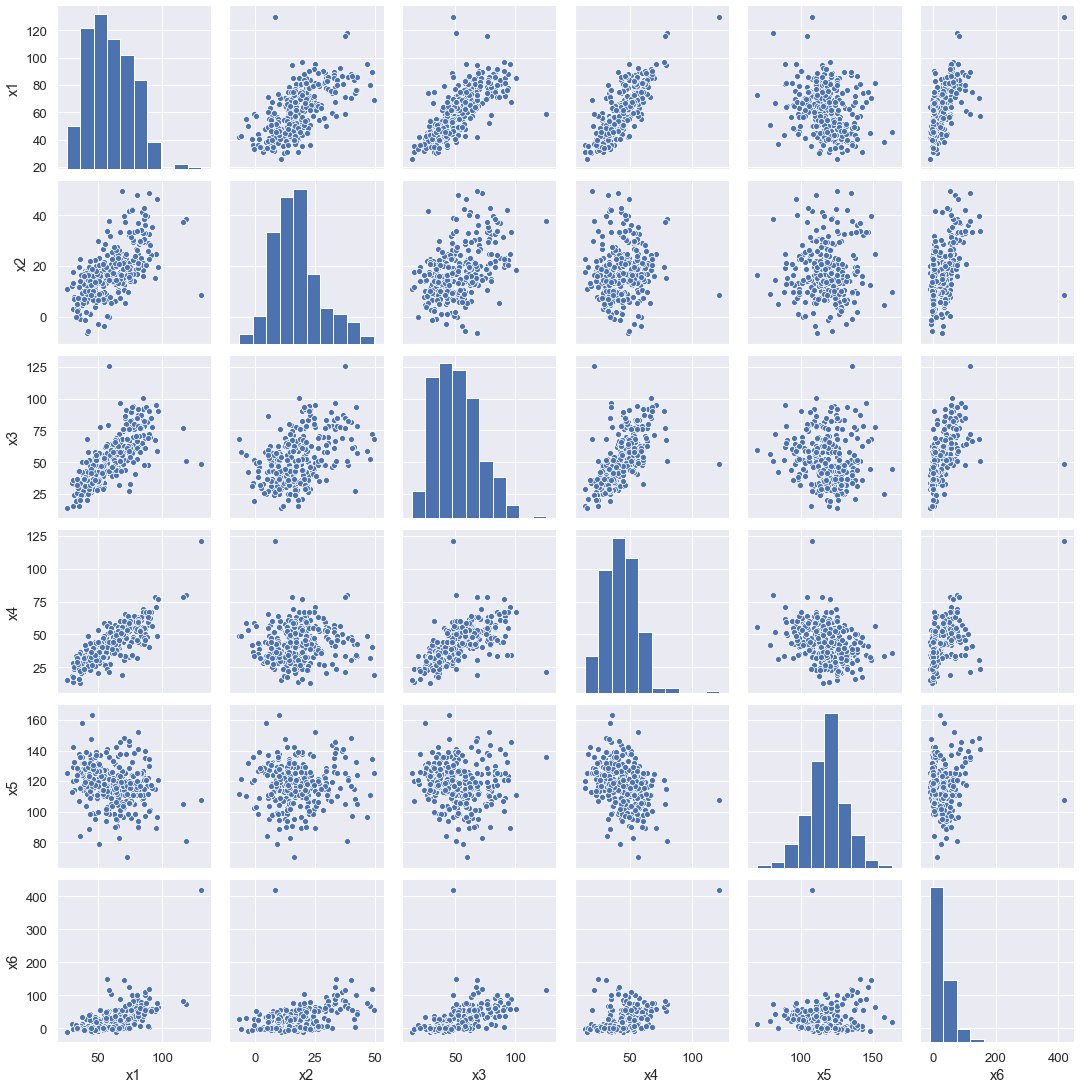

In [12]:
sns.pairplot(df)
plt.show()

### Treat Missing Values

In [13]:
df.isnull().sum()

x1    0
x2    0
x3    0
x4    0
x5    0
x6    0
y     0
dtype: int64

### Model Training

### Using PyCaret

In [14]:
exp_class = setup(data = df, target = 'y', session_id=123, normalize=True) 

 
Setup Succesfully Completed!


,Description,Value
0,session_id,123
1,Target Type,Multiclass
2,Label Encoded,"DH: 0, NO: 1, SL: 2"
3,Original Data,"(310, 7)"
4,Missing Values,False
5,Numeric Features,6
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [15]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,CatBoost Classifier,0.856900,0.000000,0.813900,0.872000,0.853800,0.770700
1,Logistic Regression,0.838100,0.000000,0.791200,0.844600,0.835500,0.740200
2,Extreme Gradient Boosting,0.833500,0.000000,0.773900,0.843900,0.826400,0.732500
3,Gradient Boosting Classifier,0.833300,0.000000,0.772000,0.839700,0.823500,0.731000
4,Quadratic Discriminant Analysis,0.828600,0.000000,0.765500,0.831400,0.819600,0.721800
5,Naive Bayes,0.823600,0.000000,0.762600,0.831500,0.814300,0.713400
6,SVM - Linear Kernel,0.814900,0.000000,0.745200,0.806800,0.797200,0.700200
7,Light Gradient Boosting Machine,0.814900,0.000000,0.759800,0.833200,0.809400,0.703500
8,Random Forest Classifier,0.814700,0.000000,0.738900,0.808000,0.798800,0.696700
9,Ridge Classifier,0.801100,0.000000,0.744600,0.811600,0.793000,0.677400


In [16]:
knn = create_model('knn')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8182,0.0,0.7554,0.8333,0.8187,0.7057
1,0.8182,0.0,0.7738,0.8455,0.8212,0.7105
2,0.9091,0.0,0.8690,0.9129,0.9083,0.8503
3,0.5909,0.0,0.5693,0.6516,0.6083,0.3674
4,0.6364,0.0,0.5905,0.6894,0.6564,0.4465
5,0.7727,0.0,0.6857,0.8314,0.7333,0.6321
6,0.7143,0.0,0.6571,0.7270,0.7184,0.5484
7,0.7143,0.0,0.6571,0.7325,0.7150,0.5435
8,0.6667,0.0,0.5738,0.6515,0.6494,0.4494
9,0.9048,0.0,0.9048,0.9365,0.9063,0.8511


In [17]:
print(knn)

OneVsRestClassifier(estimator=KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=None, n_neighbors=5,
                                                   p=2, weights='uniform'),
                    n_jobs=None)


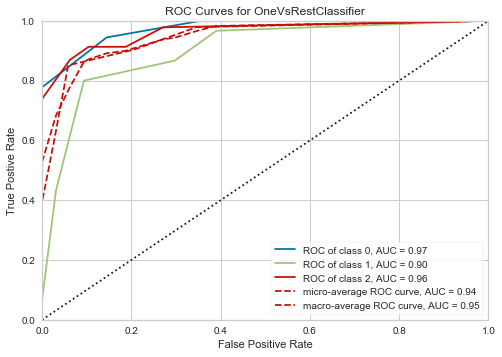

In [18]:
plot_model(knn)

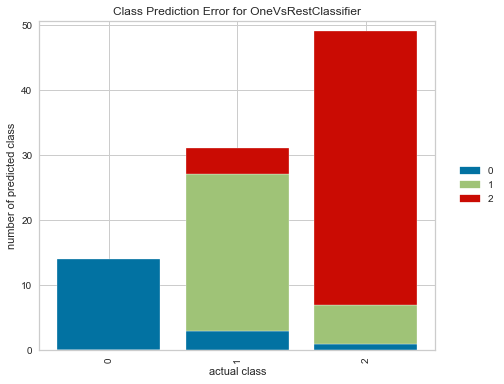

In [19]:
plot_model(knn, plot = 'error')

In [20]:
evaluate_model(knn)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [21]:
predict_model(knn)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,One Vs Rest Classifier,0.8511,0,0.8303,0.858,0.8514,0.7563


,x1,x2,x3,x4,x5,x6,y,Label,Score
0,-0.874955,-0.763903,-0.374151,-0.553229,3.395683,-0.159387,2,1,0.8
1,-1.090549,-0.529715,-1.177441,-1.005432,-0.100070,-0.734347,0,0,0.6
2,0.671393,0.716284,1.508290,0.328043,-0.808547,0.803591,2,2,1.0
3,-0.052096,1.446869,-0.289935,-1.145719,0.106005,-0.662077,0,0,0.6
4,-0.820912,-0.732878,-0.498316,-0.506964,0.250408,-0.715680,1,1,0.8
...,...,...,...,...,...,...,...,...,...
89,-0.322315,-1.168227,0.057725,0.457883,0.680608,-0.718080,1,1,0.8
90,-1.399122,-0.366584,-1.710809,-1.523300,0.613671,-0.696479,1,1,0.6
91,0.181512,-0.061339,-0.139318,0.278047,-0.062465,-0.710880,1,2,0.4
92,-0.707594,-0.009298,-0.212198,-0.901709,0.831780,-0.725547,1,1,0.6
